In [22]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
import scipy.interpolate as interpolate
import pickle

In [23]:
# -------------------------- construct the graph in networkx using adjacency matrix
def create_graph(FC, Elec_locs, sorted=0):
    # make sure you add the network nodes in order for color and index
    if sorted:
        Elec_locs_Sorted_by_Color = Elec_locs.sort_values(by=['Color', 'ROInum'])
        Nodes = list(Elec_locs_Sorted_by_Color.index.values ) 
        # mark some nodes as with_label to plot the network labels in the graph
        node_with_label = {} 
        for network in Elec_locs.System.unique():
            inds = Elec_locs[ Elec_locs.System == network ].index
            inds = np.sort( inds )
            node_with_label[network] = inds[ np.floor( inds.size / 2 ).astype(np.int8) ]
    else:
        Nodes = list(Elec_locs.index.values ) 
    # construct graphs of the connectomes
    G = nx.Graph()
    for node in Nodes:
        node_with_label_flag = ( node in list(node_with_label.values()) )
        if sorted and node_with_label_flag:
            G.add_node( node, Color= Elec_locs.loc[node, 'Color'], label=Elec_locs.loc[node, 'System_abv']) 
        else:
            G.add_node( node, Color= Elec_locs.loc[node, 'Color'], label='') 
    for ind1, node1 in enumerate(Nodes):
        for ind2, node2 in enumerate(Nodes):
            if node1 < node2:
                G.add_edge(node1, node2, weight=FC[ind1, ind2])
    return G 



# -------------------------- draw the whole network
def draw_network(G, ax=None, options=None, curved_edges=False, edge_contrast=1):
    # extract position of the nodes
    pos = nx.layout.circular_layout(G)
    if ax == None:
        ax = plt.gca()
    # plot the nodes only
    Colormap = nx.get_node_attributes(G, 'Color') 
    Node_colors = [Colormap.get(key) for key in Colormap.keys()]
    Node_sizes = [G.degree(node, weight='weight') for node in G.nodes()]
    Node_sizes = np.clip( sp.stats.zscore(Node_sizes), 0.05, 1) * options['node_size']
    Node_alphas = np.clip( sp.stats.zscore(Node_sizes), 0.3, 1)
    nx.draw_networkx_nodes(G, ax=ax, pos=pos, node_color=Node_colors, node_size=Node_sizes, alpha=Node_alphas)
    if curved_edges:
        # extract the center of mass for each community
        com_center = {}
        color_set = set( Node_colors )
        for clr in color_set:
            node_subset = [node for node in G.nodes() if (Colormap[node] == clr)]
            # average the positions (more robust than using the label node)
            com_center[clr] = np.concatenate([[pos[node]] for node in node_subset], axis=0).mean(axis=0) * 0.7
        # plot curved edges
        edge_dict = {'edge_lines': [], 'edge_colors': [], 'edge_weights': [], 'edge_alphas': []}
        for node1, node2 in list(G.edges()):
            # is the node between-network or within-network
            if Colormap[node1] ==  Colormap[node2]:
                edge_dict['edge_colors'].append( colors.to_rgb(Colormap[node1]) )
                # determine knots for the curvy line of the edge
                x = np.array( [pos[node1][0], com_center[ Colormap[node1] ][0], pos[node2][0]] )
                y = np.array( [pos[node1][1], com_center[ Colormap[node1] ][1], pos[node2][1]] )
                k_degree = 2 # degree of polynomial fit
            else:
                edge_dict['edge_colors'].append( colors.to_rgb('gray') )
                # determine knots for the curvy line of the edge
                c_temp = (com_center[ Colormap[node1] ] + com_center[ Colormap[node2] ]) / 2
                c_temp = c_temp / np.linalg.norm(c_temp) * 0.3
                x = np.array( [pos[node1][0], com_center[ Colormap[node1] ][0], c_temp[0], com_center[ Colormap[node2] ][0], pos[node2][0]] )
                y = np.array( [pos[node1][1], com_center[ Colormap[node1] ][1], c_temp[1], com_center[ Colormap[node2] ][1], pos[node2][1]] )
                k_degree = 3 # degree of polynomial fit
            # extract the curvy line
            cv = np.vstack((x, y)).transpose()
            count = cv.shape[0]
            degree = np.clip(k_degree,1,count-1)
            kv = np.clip(np.arange(count+degree+1)-degree,0,count-degree)
            max_param = count - degree
            spline = interpolate.BSpline(kv, cv, degree)
            edge_dict['edge_lines'].append( spline(np.linspace(0,max_param,100)) )
            # determine the weight of edge
            edge_dict['edge_weights'].append( G[node1][node2]['weight'] )
        # normalize edges between 0 and 1
        edge_dict['edge_weights'] = np.array( edge_dict['edge_weights'] )
        edge_dict['edge_weights'] = ( ( edge_dict['edge_weights'] - edge_dict['edge_weights'].min() ) / (edge_dict['edge_weights'].max() - edge_dict['edge_weights'].min()) ) ** edge_contrast
        # determine the alpha of edge
        edge_dict['edge_alphas'] = np.clip( edge_dict['edge_weights'], 0, 1) ** edge_contrast

        # plot all edges
        edge_collection = LineCollection(edge_dict['edge_lines'], color=edge_dict['edge_colors'], linewidth=edge_dict['edge_weights'] * options['edge_width_scaler'], linestyle='solid', alpha=edge_dict['edge_alphas'])
        ax.add_collection(edge_collection)
    else:
        edge_width = np.array( [G[u][v]['weight'] for u,v in list(G.edges())] )
        edge_width = ( ( edge_width - edge_width.min() ) / ( edge_width.max() - edge_width.min() ) ) ** edge_contrast
        edge_alpha = np.clip(edge_width, 0, 1) ** edge_contrast
        nx.draw_networkx_edges(G, ax=ax, pos=pos, width=edge_width * options['edge_width_scaler'], alpha = edge_alpha)
    ax.set_aspect(1)
    ax.axis(False)
    draw_network_labels(G, ax, options)



# -------------------------- draw cluster labels of the nodes
def draw_network_labels(G, ax, options):
    if 'label_size' in options.keys():
        label_size = options['label_size']
    else:
        label_size = 7
    pos = nx.layout.circular_layout(G)
    rotation = {}
    for node in G.nodes():
        x = pos[node][0] * 1.1
        y = pos[node][1] * 1.1
        angle = np.arctan(pos[node][1] / pos[node][0]) / np.pi * 180
        rotation = (angle - 90) + ( pos[node][0] < 0 ) * 180
        ax.text(x, y, G.nodes[node]['label'], rotation=rotation, fontsize=label_size, ha='center', va='center')


# -------------------------- load node information
def load_Elec_locs():
    with open('Elec_locs.pkl', 'rb') as f:
        Elec_locs = pickle.load(f)    
    f.close()        
    return Elec_locs

In [24]:
# -------------------------- load node information
Elec_locs = load_Elec_locs()
N = len(Elec_locs)
Elec_locs.head(10)

Position,X,Y,Z,Color,System,System_abv
ROInum,,,,,,
1,-24.66,-97.84,-12.33,White,Uncertain,N/A
2,26.68,-97.3,-13.49,White,Uncertain,N/A
3,23.96,31.94,-17.78,White,Uncertain,N/A
4,-56.16,-44.76,-24.23,White,Uncertain,N/A
5,8.13,41.12,-24.31,White,Uncertain,N/A
6,-21.38,-22.22,-19.97,White,Uncertain,N/A
7,17.44,-28.06,-17.32,White,Uncertain,N/A
8,-37.26,-28.8,-25.58,White,Uncertain,N/A
9,64.6,-24.41,-18.57,White,Uncertain,N/A


In [69]:
# -------------------------- create the network from its Adjacency matrix
FC = np.random.randn(N, N)
# make it symmetric
FC = ( np.tril(FC) + np.tril(FC).transpose() ) / 2
# threshold the edges
FC = np.where(FC > 1, FC, 0)
# construct the network
G = create_graph(FC, Elec_locs=Elec_locs, sorted=1)

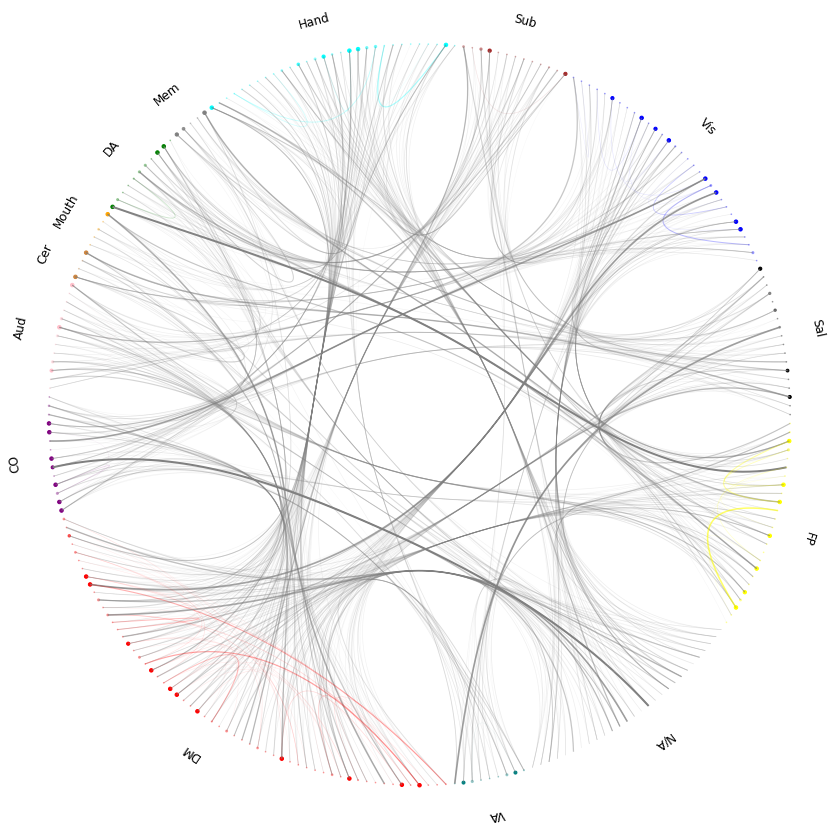

In [72]:
# -------------------------- Draw the network
options = {
'node_size': 12,
'label_size': 12,
'edge_width_scaler': 2,
'with_labels': False,
'edge_color': 'gray'
}

# plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
fig.set_facecolor('white')
draw_network(G, ax=ax, options=options, curved_edges=True, edge_contrast=2)